# Z from RMS

## This notebook:

- Selects events with 1 S1 and 1 S2.
- Uses Zrms (= RMS of the S2 waveform) as an estimator of Z
- Computes the quantity Zrms - Z (where Z is obtained as the difference between S1 and S2)

## Authors: JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

### Description:

- Run 6817. January 2019. Low background run, closed castle, sources, 7.7 kV


In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Mon Feb  4 19:44:22 2019


In [2]:
run_number  = 6817
file_range  = 0, 10000

input_path  = f"$IC_DATA/kdst"
output_path = f"$IC_DATA/dst"
log_path    = f"$IC_DATA/log"
trigger     = 'trigger1'
tags        = 'v0.9.9_20190111_krth'

bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run6206.h5"
write_filtered_dst = True

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [4]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import tables            as tb
import random
import glob
import seaborn as sns
sns.set()

In [5]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units


In [6]:
from krcal.core.io_functions       import filenames_from_paths
from krcal.core.io_functions       import write_monitor_vars
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2d, plot_histo

In [7]:
from krcal.core.kr_types           import PlotLabels
from krcal.core.analysis_functions import kr_ranges_and_bins
from krcal.core.analysis_functions import kr_event
from krcal.core.analysis_functions import selection_info
from krcal.core.analysis_functions import selection_in_band
from krcal.core.analysis_functions import plot_selection_in_band
from krcal.core.s1s2_functions     import s1d_from_dst
from krcal.core.s1s2_functions     import s2d_from_dst
from krcal.core.s1s2_functions     import plot_s1histos
from krcal.core.s1s2_functions     import plot_s2histos

In [8]:
from krcal.core.plt_functions      import plot_xy_density
from krcal.core.plt_functions      import plot_s1_vs_z
from krcal.core.plt_functions      import plot_s2_vs_z
from krcal.core.plt_functions      import plot_s2_vs_s1
from krcal.core.plt_functions      import plot_q_vs_s2
from krcal.core.plt_functions      import plot_energy_distributions
from krcal.core.plt_functions      import plot_energy_vs_t


In [9]:
import krcal.dev.corrections       as corrections 
import krcal.utils.hst_extend_functions as hst

In [10]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core import fit_functions_ic as fitf
from krcal.core.histo_functions import profile1d

### Input/output 

In [11]:
input_dst_filenames, output_dst_filename, log_filename = filenames_from_paths(run_number,
                                                                              input_path,
                                                                              output_path,
                                                                              log_path,
                                                                              trigger,
                                                                              tags,
                                                                              file_range)
                                                                              
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"log file   = {log_filename}")                       

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6817/kdst_0000_6817_trigger1_v0.9.9_20190111_krth.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6817/kdst_9999_6817_trigger1_v0.9.9_20190111_krth.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6817_trigger1_0000_9999.h5
log file   = /Users/jjgomezcadenas/Projects/ICDATA/log/log_6817_trigger1_0000_9999.h5


In [12]:
dst_full           = load_dsts(input_dst_filenames, "DST", "Events")

/Users/jjgomezcadenas/Projects/IC/invisible_cities/io/dst_io.py:21: UserWarning:  does not exist: file = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6817/kdst_5824_6817_trigger1_v0.9.9_20190111_krth.h5 
  warnings.warn(f' does not exist: file = {filename} ', UserWarning)


In [13]:
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 3454543 
Total number of events: 2039174


In [14]:
dst_full.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [15]:
ntot = len(dst_full)
print(f"length of dst = {ntot}")

length of dst = 3454543


In [16]:
RMAX      = 200
RFID      = 180
RCORE     = 100
s1e_range = (1, 25)
s2e_range = (1000, 15000)
s2w_range =(4, 15)
s2q_range = (200, 800)
Nsipm_min = 10
xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 6000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst_full,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 50,
                                                        s2enbins  = 50,
                                                        s1enbins  = 50,
                                                        s2qnbins  = 50,
                                                        tpsamples = 3600) # tsamples in seconds

### Time
- Extension in hours of data sample considered

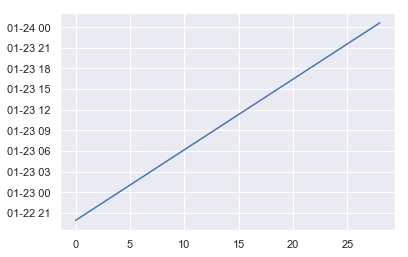

In [17]:
plt.plot(krTimes.timeStamps)

### S1/S2

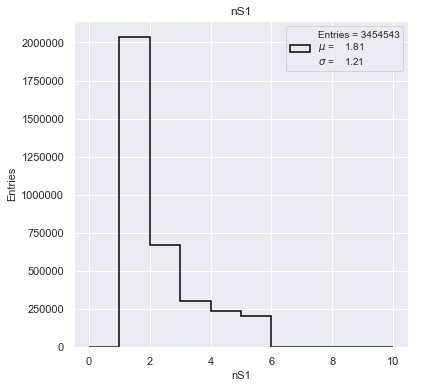

In [18]:
n, b, _, _ = h1d(dst_full.nS1.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS1', y='Entries', title='nS1'))

In [19]:
fnS1 = n[n.argmax()]/np.sum(n)
print(f'fraction of S1s = {fnS1}')

fraction of S1s = 0.5899061033543366


#### Fraction of events with 1 S1 is 0.5. For Krypton select events with 1 S1

### Select events with 1 S1

In [20]:
dst1s1 = dst_full[dst_full.nS1==1]

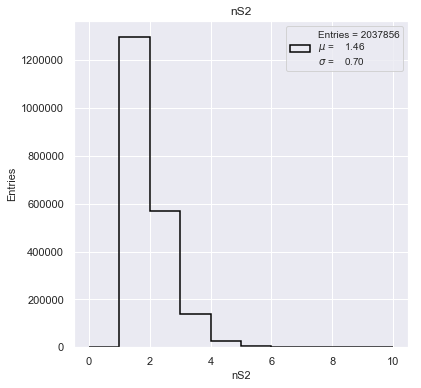

In [21]:
n, b, _, _ = h1d(dst1s1.nS2.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS2', y='Entries', title='nS2'))

#### For Krypton select events with only 1 S2

In [22]:
fnS2 = n[n.argmax()]/np.sum(n)
print(f'fraction of S2s = {fnS2}')

fraction of S2s = 0.6370607147904465


### Select events with 1 S2

In [23]:
dst    = dst1s1[dst1s1.nS2==1]

In [24]:
n_full   = len(dst)
eff = n_full   / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {n_full}: selection eff = {eff} ")

Total number of events with 1 s1 and 1 s2 : 1298238: selection eff = 0.3758060038621606 


### S1 and S2 distributions

In [25]:
s1d = s1d_from_dst(dst)

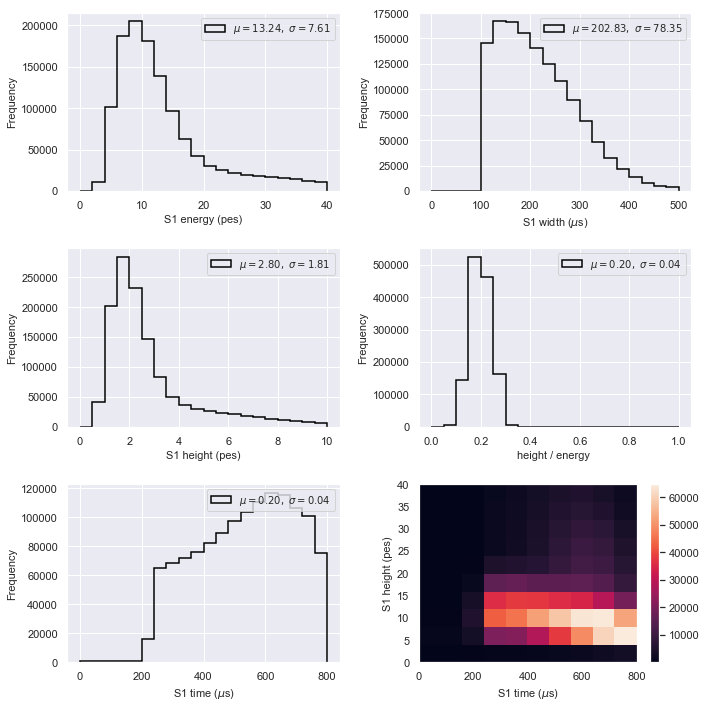

In [26]:
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

#### Notice the bias in S1 time (which corresponds to the bias on Z)

## Fiducial selection 

In [27]:
dst_s1e    = dst[in_range(dst.S1e, *s1e_range)] 
dst_s2e    = dst_s1e[in_range(dst_s1e.S2e, *s2e_range)] 
dst_s2w    = dst_s2e[in_range(dst_s2e.S2w, *s2w_range)]
dst_sipm   = dst_s2w[dst_s2w.Nsipm > Nsipm_min] 
dst_s2q    = dst_sipm[in_range(dst_sipm.S2q, *s2q_range)]
dst       = dst_s2q

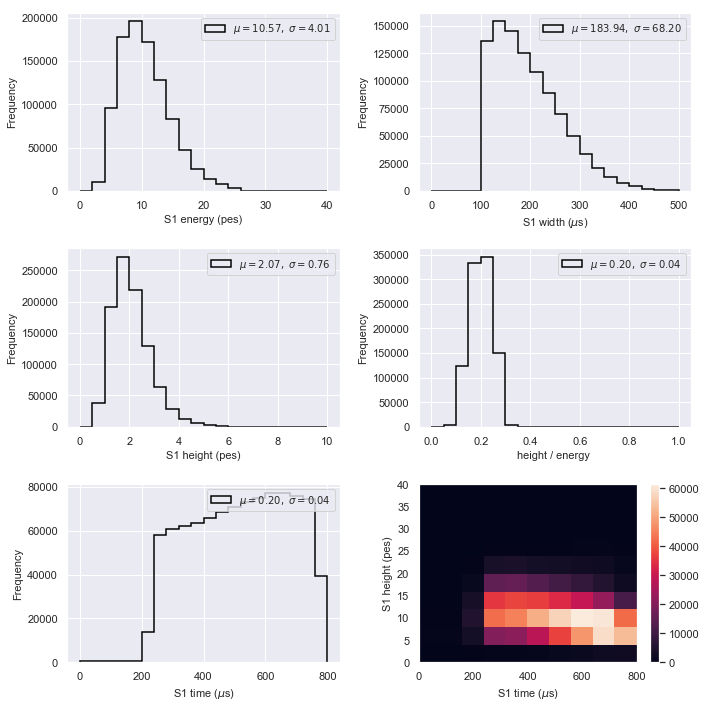

In [28]:
s1d = s1d_from_dst(dst)
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

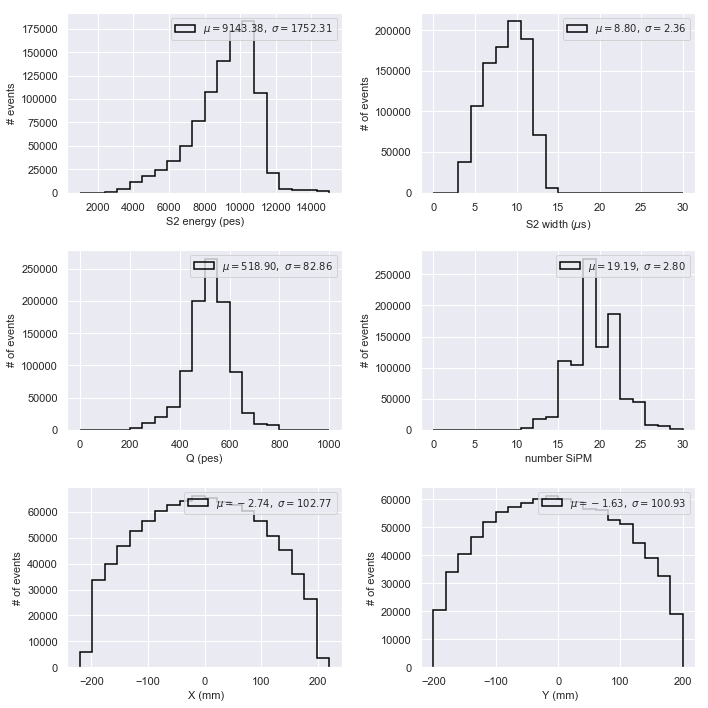

In [29]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

### Apply bootstrap corrections.

- One can correct S2e and S2q by geometrical corrections using an existing map (a bootstrap map). This has the effect to reduce the geometrical dependence on both distributions, permitting an additional filtering

In [30]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

In [31]:
kre = kr_event(dst)

In [32]:
bootstrap_correction_filename = os.path.expandvars(bootstrap_correction_filename)
calibrate = corrections.Calibration(bootstrap_correction_filename)
E, Q = calibrate(kre.X, kre.Y, None, kre.T, kre.S2e, kre.S2q)

In [33]:
kge = kr_event(dst, DT, E, Q)

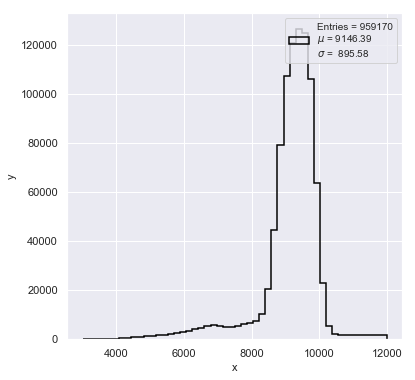

In [34]:
(_) = h1d(kge.E, bins = 50, range =(3000,12000))

#### Plot of E and Q corrected vs Z shows much less spread (XY corrections applied only remaining LT corrections)

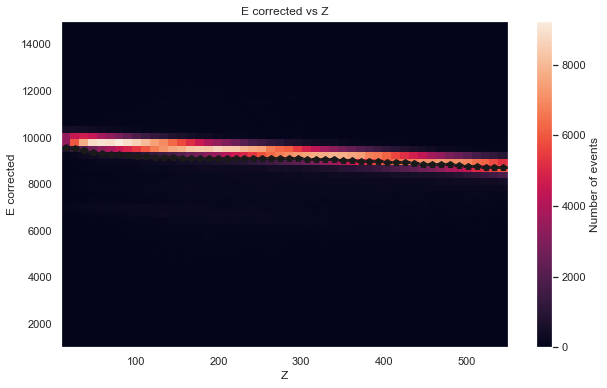

In [35]:
nevt = h2d(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z', y='E corrected', title='E corrected vs Z'),
           profile=True,
           figsize=(10,6))

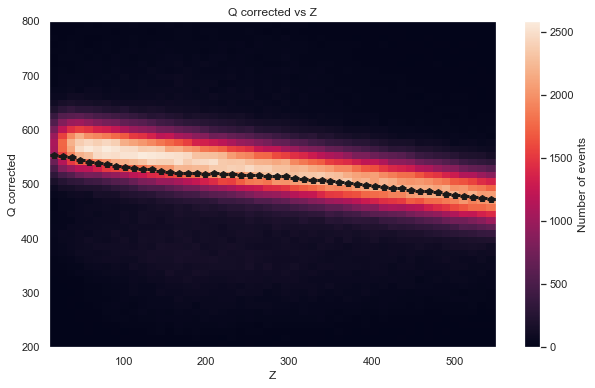

In [36]:
nevt = h2d(dst.Z, Q, krNbins.Z, krNbins.S2q, krRanges.Z, krRanges.S2q, 
           pltLabels=PlotLabels(x='Z', y='Q corrected', title='Q corrected vs Z'),
           profile=True,
           figsize=(10,6))

### Filter

In [37]:
range_krs2 = (8e+3,12e+3)

In [38]:
sel_krband, fpl, fph, hp, pp = selection_in_band(kre.Z, E,
                                                 range_z = krRanges.Z,
                                                 range_e = range_krs2,
                                                 nbins_z = 50,
                                                 nbins_e = 50,
                                                 nsigma  = 3.5)

/Users/jjgomezcadenas/Projects/ICAROS/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jjgomezcadenas/Projects/ICAROS/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)


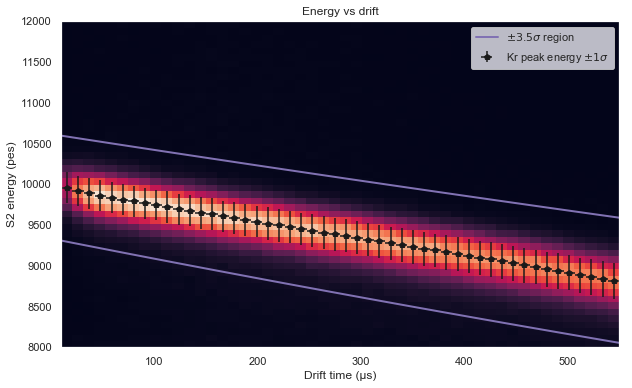

In [39]:
plot_selection_in_band(fpl, fph, hp, pp)

In [40]:
selection_info(sel_krband, 'Kr band')

Total number of selected candidates Kr band: 813875 (84.9 %)


'Total number of selected candidates Kr band: 813875 (84.9 %)'

In [41]:
kges = kr_event(dst, DT, E, Q, sel_mask=sel_krband)

### Energy before and after filter

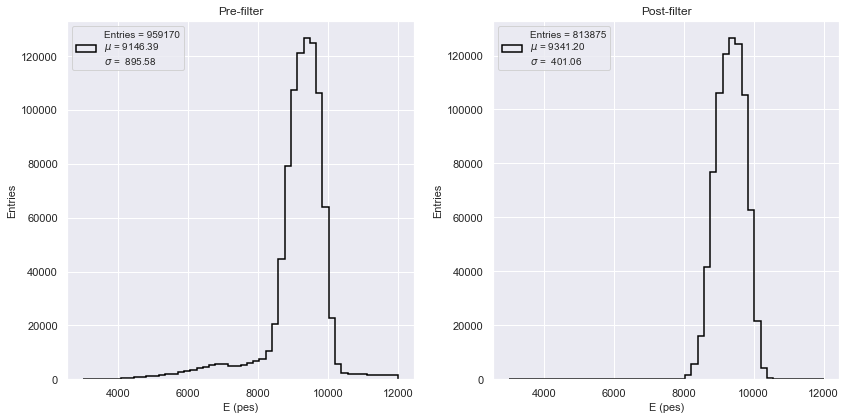

In [42]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 2, 1)
(_)     = h1(kge.E,  bins = 50, range =(3000,12000))
plot_histo(PlotLabels('E (pes)','Entries','Pre-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(kges.E,  bins = 50, range =(3000,12000))
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
plt.tight_layout()

### Select dst 

In [43]:
dsts = dst[sel_krband]

### Select fiducial region in R

In [44]:
dstf     = dsts[dsts.R < RFID]

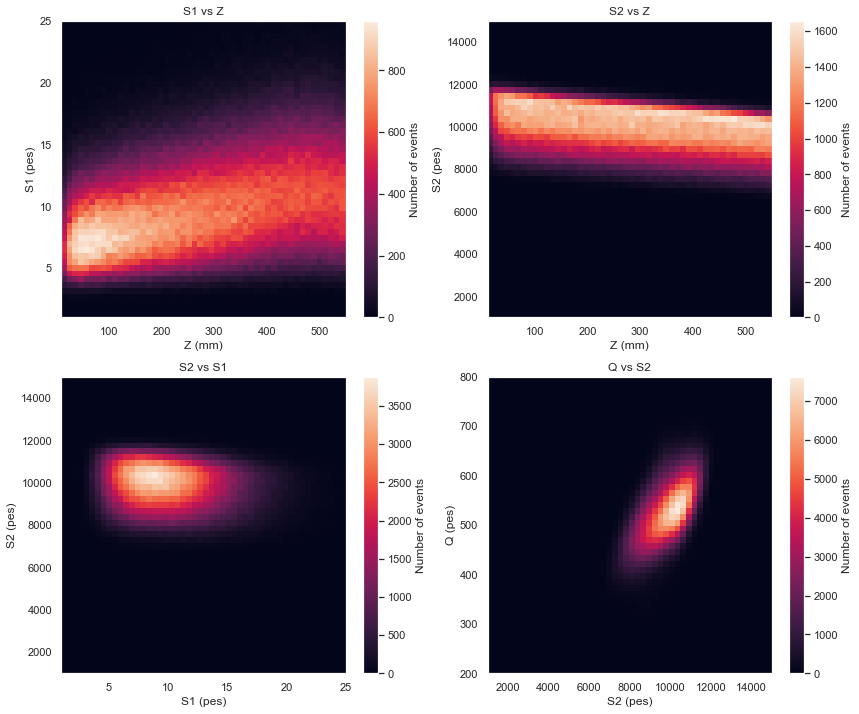

In [45]:
plot_energy_distributions(dstf, krBins.Z, krBins.S1e, krBins.S2e, krBins.S2q, figsize=(14,12))

### S1 distributions in selected + fiducial

warning, empty slice of x = [734400. 490350. 598325. ... 678325. 603950. 231100.] in range = (0, 600)
returning mean and std of x = [734400. 490350. 598325. ... 678325. 603950. 231100.]


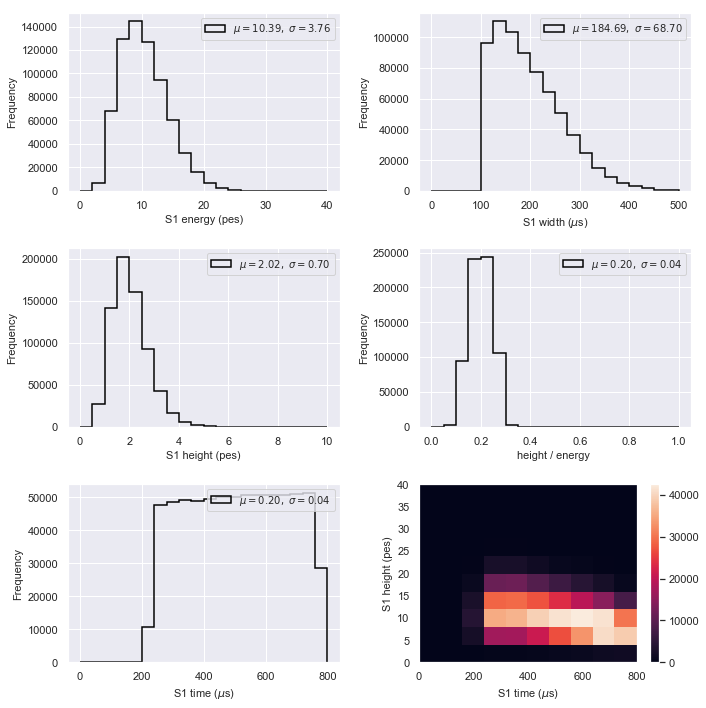

In [46]:
s1d = s1d_from_dst(dstf, range_s1e = s1e_range)
plot_s1histos(dstf,  s1d, bins=20, figsize=(10,10))

### No bias in Z

### X vs Y again

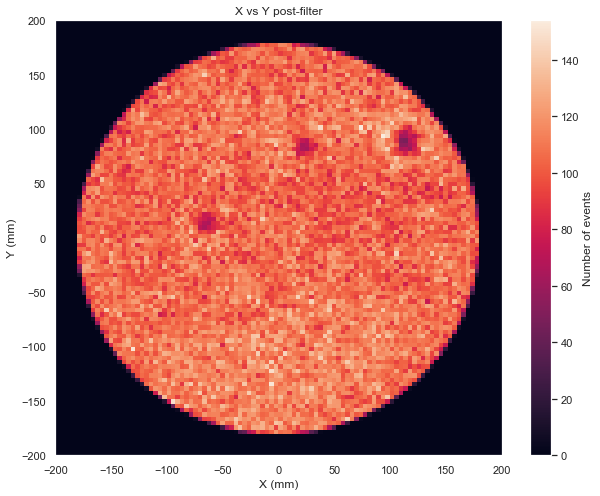

In [47]:
nevt = h2d(dstf.X, dstf.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y post-filter'),
           profile=False,
           figsize=(10,8))

## Z vs Zrms (= rms of the S2 waveform)

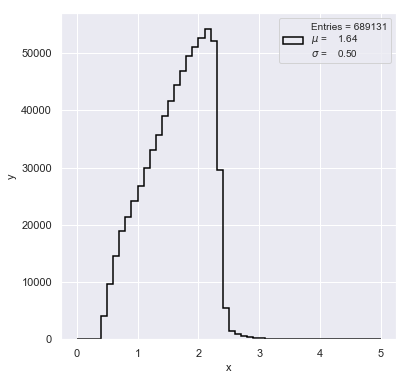

In [48]:
(_) = h1d(dstf.Zrms, bins = 50, range =(0,5))

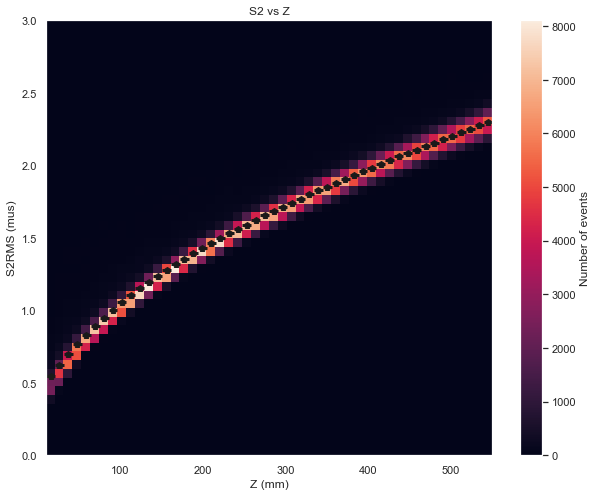

In [49]:
nevt = h2d(dstf.Z, dstf.Zrms, 50, 50, (10,550), (0,3), 
           pltLabels=PlotLabels(x='Z (mm)', y='S2RMS (mus)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

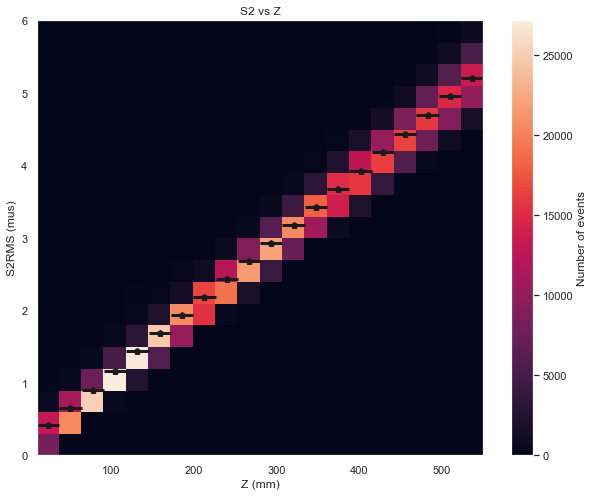

In [50]:
nevt = h2d(dstf.Z, dstf.Zrms * dstf.Zrms, 20, 20, (10,550), (0,6), 
           pltLabels=PlotLabels(x='Z (mm)', y='S2RMS (mus)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [51]:
x, y, yu  = profile1d(dstf.Z, dstf.Zrms * dstf.Zrms, 20, range_z=(10, 500))

In [52]:
fh     = fitf.fit(fitf.polynom, x, y, seed=(1,1), fit_range=(10,500), sigma=0.01*y)

In [53]:
fh

FitFunction(fn=<function fit.<locals>.<lambda> at 0x1a26b9b158>, values=array([0.1947821, 0.0093112]), errors=array([3.60562570e-03, 3.11953263e-05]), chi2=1.0130224860489978, pvalue=0.44031407724065447, cov=array([[ 1.30005367e-05, -7.40748986e-08],
       [-7.40748986e-08,  9.73148382e-10]]))

Text(0, 0.5, 'Zrms2')

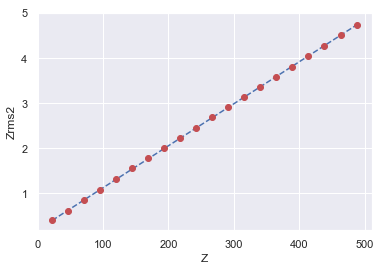

In [54]:
plt.errorbar(x, y,  yerr=0.01*y, fmt='ro')
plt.plot(x, fh.fn(x), 'b--')
plt.xlabel('Z')
plt.ylabel('Zrms2')

In [55]:
def z_from_s2rms(s2rms : np.array,  fh)->np.array:
    zr = (s2rms * s2rms - fh.values[0]) / fh.values[1]
    return zr 

In [56]:
zs2w = z_from_s2rms(dstf.Zrms, fh)

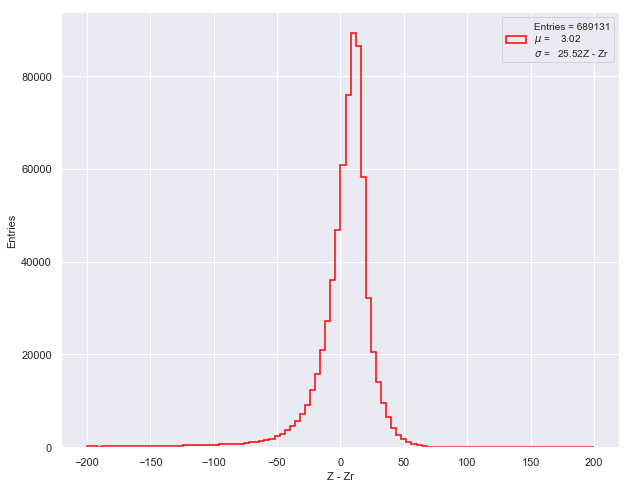

In [57]:
fig = plt.figure(figsize=(10,8))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(dstf.Z - zs2w, bins=100, range = (-200,200), color='red', stats=True, lbl='Z - Zr')
plot_histo(PlotLabels('Z - Zr','Entries',''), ax)

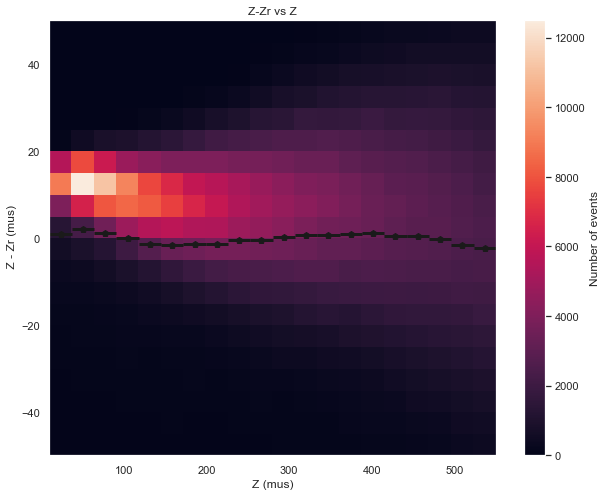

In [62]:
nevt = h2d(dstf.Z, dstf.Z - zs2w, 20, 20, (10,550), (-50,50), 
           pltLabels=PlotLabels(x='Z (mus)', y=' Z - Zr (mus)', title='Z-Zr vs Z'),
           profile=True,
           figsize=(10,8))

In [58]:
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from krcal.core.fit_energy_functions       import gaussian_parameters
from krcal.core.fit_energy_functions       import gaussian_fit

In [59]:
rng     = (-50,50)
nbins   = 25
n_sigma = 3
y, b = np.histogram(dstf.Z - zs2w, bins= nbins, range=rng)
x = shift_to_bin_centers(b)
bin_size = (rng[1] - rng[0]) / nbins
seed = gaussian_parameters(dstf.Z - zs2w, rng, bin_size)


In [60]:
fp, fr = gaussian_fit(x, y, seed, n_sigma)

FitResult(par=array([2.42319636e+06, 6.94127354e+00, 1.41018830e+01]), err=array([3.11565751e+03, 1.84542724e-02, 1.56661624e-02]), chi2=42.849433734932134, valid=True)

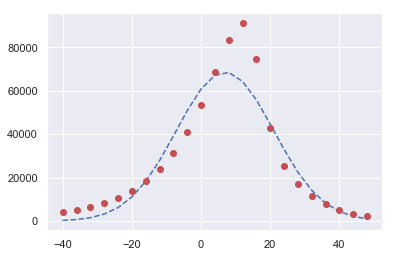

In [61]:
plt.errorbar(fp.x, fp.y,  yerr=fp.yu, fmt='ro')
plt.plot(fp.x, fp.f(fp.x), 'b--')
fr

## Outlook:

- Sample of krytpon events cleaned from backgrounds and restricted to fiducial region (R<180)
- For this sample Zrms and Z can be fitted to a straight line and an estimator of Z (Zr) can be obtained.
- The distribution (Z - Zr) is slightly displaced from zero (if radial cut is relaxed the displacement increases). The distribution is non gaussian and has long tails, in particular to the left side of the distribution. 
- The rms of the distribution is large (~25 mm)

#### The non-gaussian tails and large rms are a certain source of systematics is Zrms is used as an estimator of Z.

## End of NB